# Content 

This notebook contains an example of voltage optimization for ion shuttling and MD simulation of this shuttling. The route of the shuttling is optimized according to the principles, listed in 
https://doi.org/10.48550/arXiv.quant-ph/0702175.

In general, the similar approach can be applied to any simulation of surface trap with time-varying voltages.

In [7]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from __future__ import division
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped)
import sion as sn
import sys
from pathlib import Path
import pylion as pl
import time



#puts python plots inline with the code
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Trap definition

[ -5.          99.98772773 199.84782739]
[0.0, 14.39363013058722, -14.99999998770957, 14.999998334544795, 14.401942248277663, -14.999999999999998, 14.999998388907589, 1.2358866977600327]
secular frequencies: (0.8192, 1.432, 2.414) MHz
in directions
a: [9.99999758e-01 6.12299090e-05 6.92874472e-04] 
b: [-6.13354395e-05  9.99999987e-01  1.52288070e-04] 
c: [-6.92865138e-04 -1.52330531e-04  9.99999748e-01]


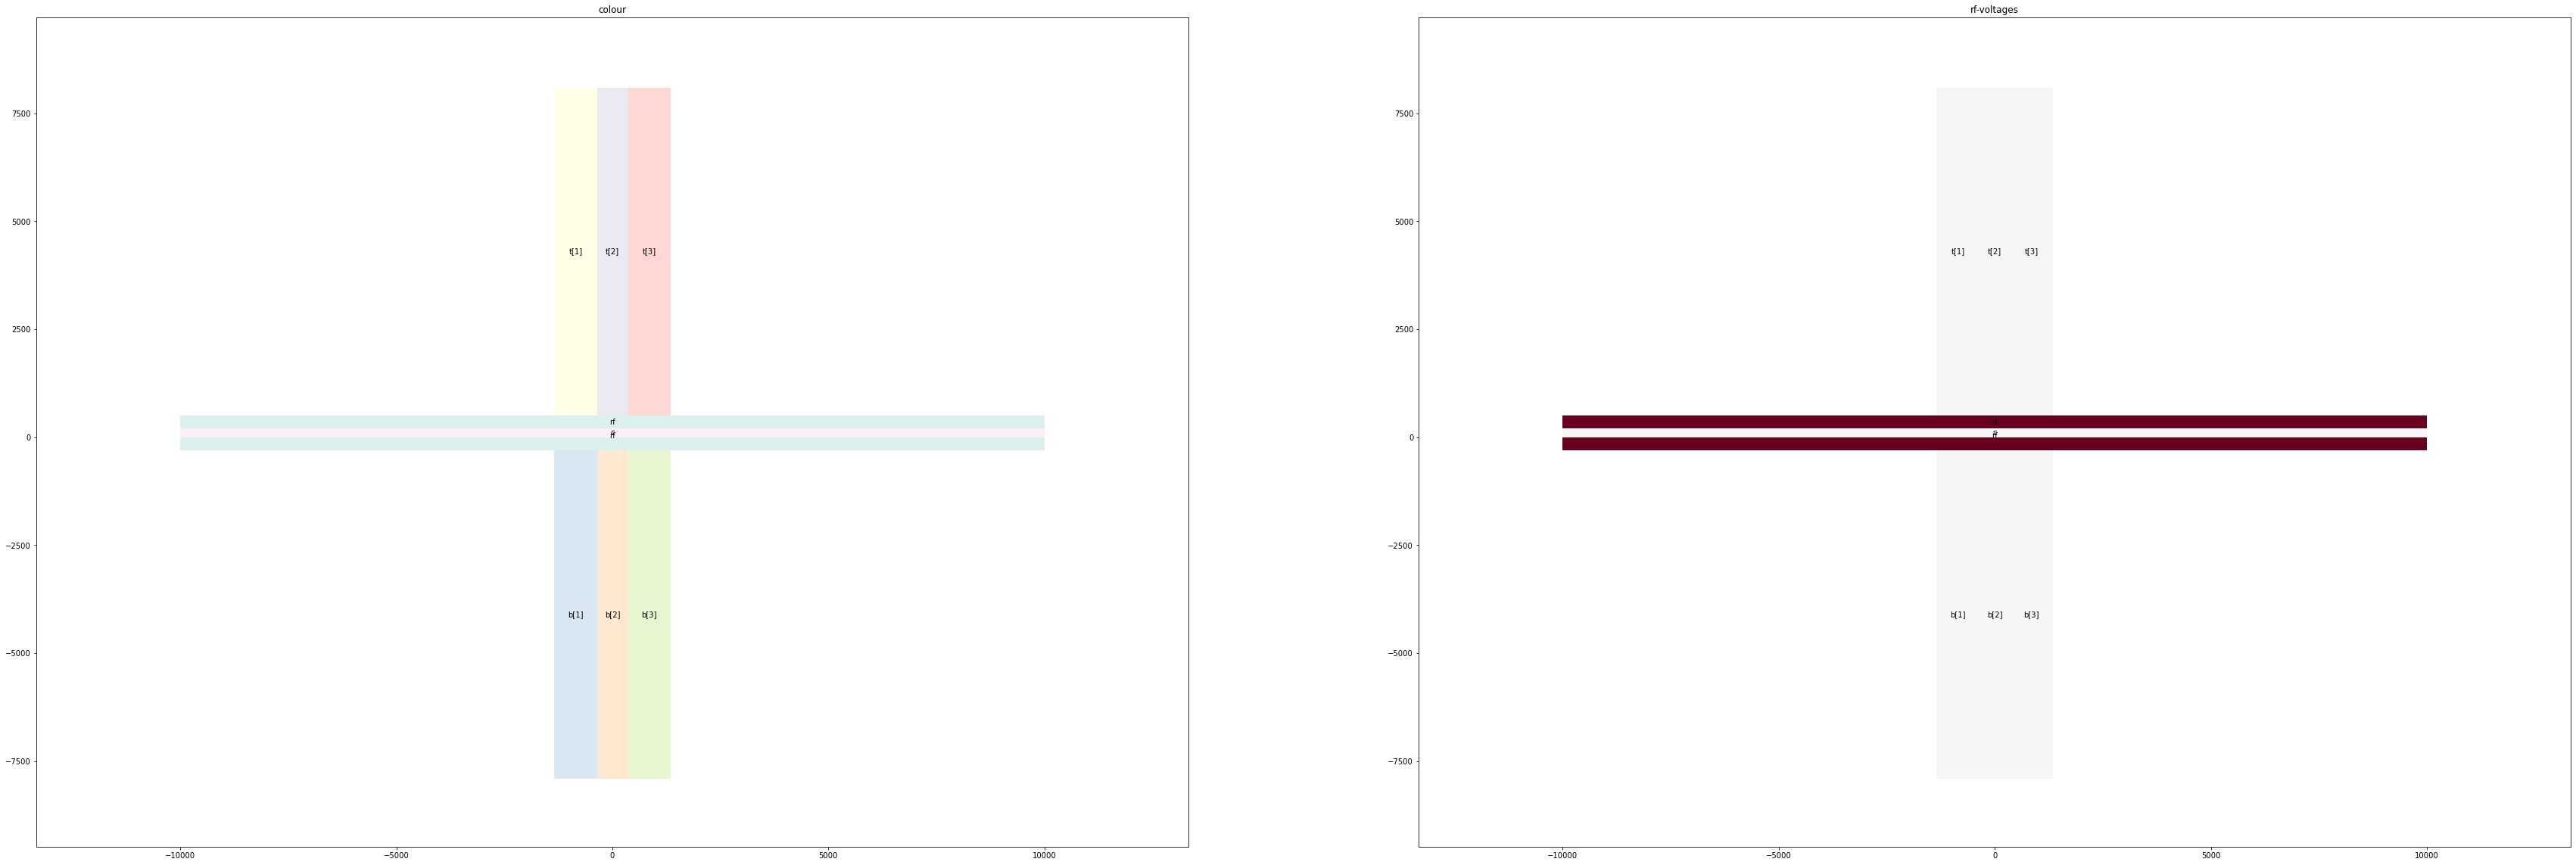

In [8]:
# define trap with large anharmonicity 
L = 1e-6 # length scale
Vrf = 50# RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*8e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)


# parameters of trap
DCtop = [[7600, 1000],[10000-2400, 700],[7600, 1000]  ]  # Array of lengths and widths of Top electrodes
DCbottom = [[7600, 1000],[10000-2400, 700],[7600, 1000]  ]  # Array of lengths and widths of Bottom electrodes
cwidth = 200# Width of central dc electrode
clength = 20000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 300  # width of top rf electrode, not including width of central electrode
rflength = 20000  # length of rf electrodes
rfbottom = 300  # width of bottom rf electrode
patternTop = 1  # number of groups of Top dc electrodes, defined in DCtop. if None then = 1
patternBot = 1  # same for bottom dcs
getCoordinate = None  # If not None, writes a file with coordinates of vertexes of electrodes
gapped = 0  # gaps between central DC electrode and RF lines
cheight = 1000  # height of the grounded cover electrode plane
cmax = 0  # order of the expansion of cover potential. if 0 - coder not considered, if 5 - considered with optimal precision
elec, Numb, s = sn.FiveWireTrap(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, patternTop, patternBot, getCoordinate, gapped, cheight, cmax,1)

x0 = np.array(s.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
x0 = x0 - np.array([5, 0, 0])
print(x0)

s1 = System([e for e in s if not e.rf])
# Give the constraints for system.shims
derivs = "xx x y z ".split()
u_cal = s1.shims((x0 , None, deriv) for deriv in derivs)
# Define variables for confinement in x-direction (uxx) and shim voltage sets (ux,uy,uz)
uxx = 1*np.array(u_cal[0])
ux = 1*np.array(u_cal[1])
uy = 1*np.array(u_cal[2])
uz = 1*np.array(u_cal[3])

## # Define the voltage set for confinement in x-direction
u_set = [0]
for i in range(Numb):
    u_set.append(uxx[i])
u_set = 15*np.array(u_set)/np.max(np.abs(u_set))
print(list(u_set))

x0 = x0 - np.array([0, 0, 0])

with s.with_voltages(dcs = u_set, rfs = None):
    x0 = np.array(s.minimum( x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    curv_z, mod_dir=s.modes(x0 ,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    #print(sn.anharmonics(sist, [x1], 0, L))

# Pseudopotential distribution

To check, if we have sufficient trap depth.

RF pseudopotential minimum: 0.4445 eV at (-5, 100, 200)µm
secular frequencies: (0.8192, 1.432, 2.414) MHz
in directions
a: [9.99999758e-01 6.12299090e-05 6.92874472e-04] 
b: [-6.13354395e-05  9.99999987e-01  1.52288070e-04] 
c: [-6.92865138e-04 -1.52330531e-04  9.99999748e-01]


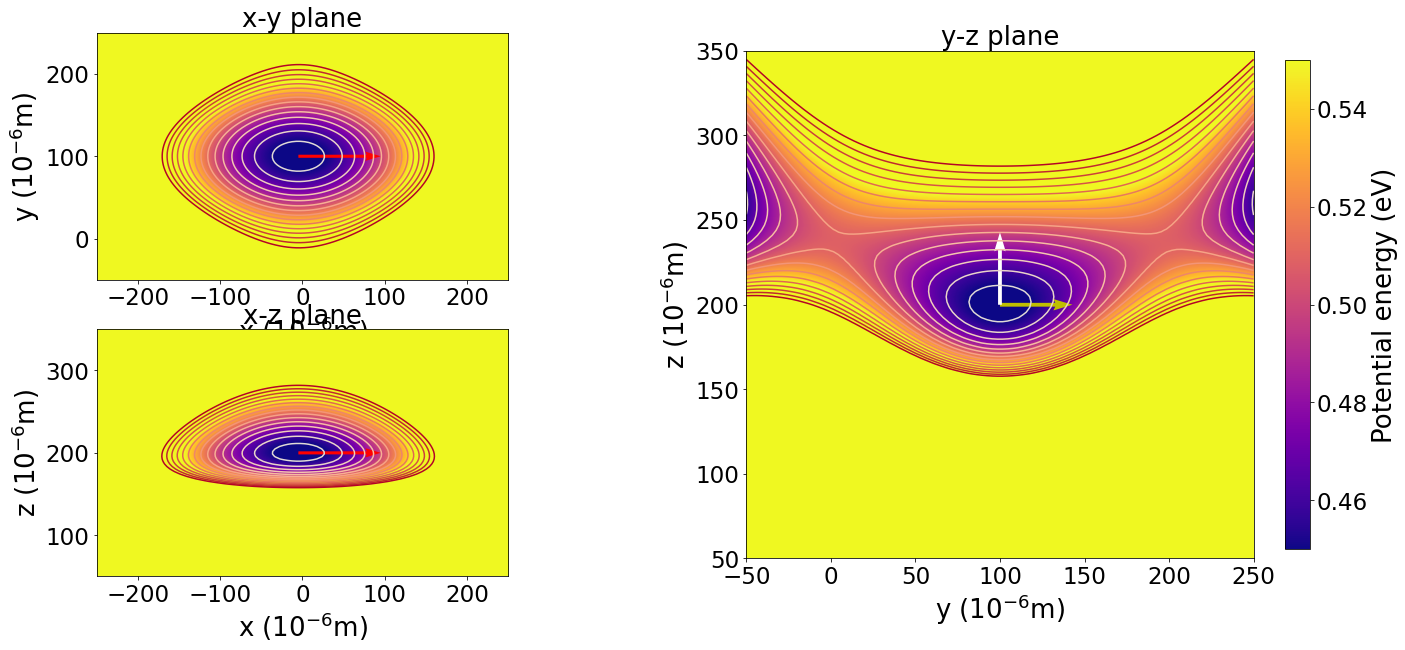

In [9]:

with s.with_voltages(dcs = u_set, rfs = None):
#     try:
    x0 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    p_tot0=s.potential(x0, 0)[0]
    print("RF pseudopotential minimum: %.4g" % p_tot0,"eV at (%.3g, %.3g, %.3g)µm" % (x0[0], x0[1], x0[2]))
#     except:
#         x0 = x_ini

    curv_z, mod_dir=s.modes(x0,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)

    # 2D plot settings

    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -250, 250 #set the plot ranges
    ymin, ymax = -50, 250
    zmin, zmax = 50, 350
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(0.3,0.6, 0.01)# set the range for contour lines (range in eV)
    v_min, v_max = 0.45, 0.55 #set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,10)

    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')

    # x-z cross section
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')

    # y-z cross section
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
    ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 

    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.9)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)

    #add secular frequencies
    #change color and scale (the fewer, the longer the arrow)
    ax1.quiver(*[[x0[0]],[x0[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
    ax2.quiver(*[[x0[0]],[x0[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)
    

# Shuttling process

We will start from the position -5 mkm, and shuttle ion by 10 mkm in axial direction. In general it is beneficial to separate the full shuttling distance into steps with smaller shuttling distance. *Sion* optimizes voltage sequence on DC electrodes to perform shuttling according to the tanh route with the conversion of the axial secular frequency to minimize heating. 

The following block performs voltage optimization (*sion.linear_shuttling_voltage()*) and mapping of voltage sequence to the analytic functions, suitable for optimization (*sion.approx_shuttling()*).

## Expected and resulting x(t) dependency

Optimization took: 146.36362624168396 seconds


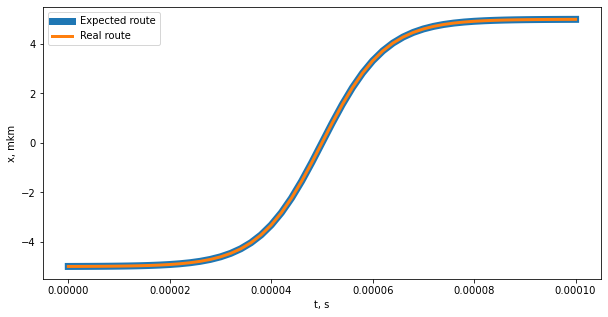

In [10]:
d = 10
T = 1e-4
N = 4
vmin = -15
vmax = 15
res = 50
L = 1e-6

start_time = time.time()
voltage_seq = sn.linear_shuttling_voltage(s, x0, d, T, N, u_set, vmin, vmax, res, L)
print("Optimization took:", time.time()-start_time, "seconds")

# we wish to obtain the following function of x(t)
def q_tan(t, d, T, N):
    return d/2*(np.tanh(N*(2*t-T)/T)/np.tanh(N) + 1)

# let's calculate real positions of potential minimum at each time step 
xex = []
xx = []
omegas = []
omegas_z = []
voltage_seq = voltage_seq.T
for dt in range(res+1):
    t = dt*T/res
    x = x0 + np.array([q_tan(t, d, T, N), 0, 0])
    xex.append(x[0])
    u_set = [0]
    u_set.extend(voltage_seq[dt])
    with s.with_voltages(dcs = u_set, rfs = None):
        x1 = s.minimum(np.array(x), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        xx.append(x1[0])
        curv_z, mod_dir=s.modes(x,sorted=False)
        omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
        omegas.append(omega_sec[0])
        omegas_z.append(omega_sec[2])
        
voltage_seq = voltage_seq.T

fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(res+1)*T/res,xex,linewidth = 7, label = 'Expected route')
plt.plot(np.arange(res+1)*T/res, xx,linewidth = 3, label = 'Real route')

plt.xlabel('t, s')
plt.ylabel('x, mkm')
plt.legend()

plt.show()

## Axial secular frequency conserving

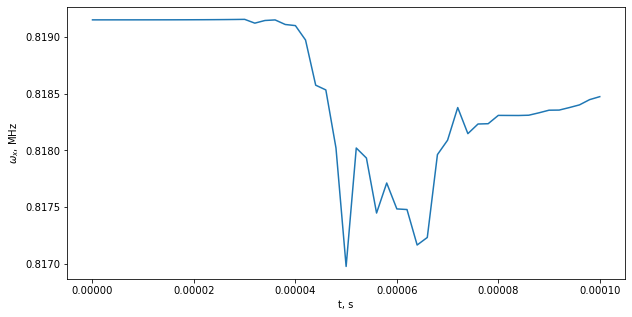

In [11]:
fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(res+1)*T/res, omegas)

plt.xlabel('t, s')
plt.ylabel('$\omega_{x}$, MHz')

plt.show()


## Radial secular frequency

Check variations in radial secular frequency, so it doesn't exceed stability threshold (approximately Omega/3). 

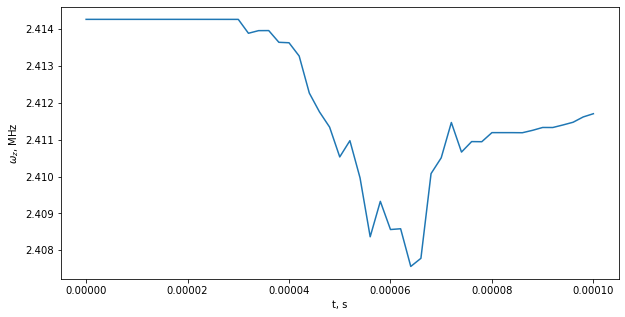

In [12]:
fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(res+1)*T/res, omegas_z)

plt.xlabel('t, s')
plt.ylabel('$\omega_{z}$, MHz')

plt.show()


## Resulting voltage sequence and it's approximation

LAMMPS must obtain analytic time-dependent function to perform correct simulation. That is why it's necessary to get analytic approximation for our DC voltage schedule. *Sion* performs either constant, tanh or normal distribution-like approximations, and fits voltage schedule with the most suitable.

From the form of the V(t) you can see, that you may feed *sion.polygon_shuttling()* function with any analytic expression in string format, where *time* parameter is replaced with "step\*dt" string.  

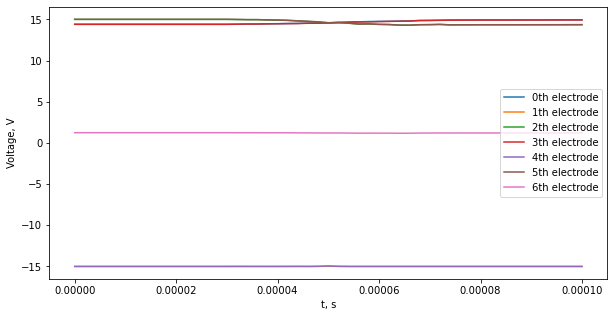

0 electrode voltage: V(t) = ((0.279) * (1 - 2/(exp(2*((61284.969) * step*dt + (-3.339))) + 1)) + (14.666))
1 electrode voltage: V(t) = (-14.998)
2 electrode voltage: V(t) = ((0.332) * (1 - 2/(exp(2*((-105348.976) * step*dt + (5.089))) + 1)) + (14.669))
3 electrode voltage: V(t) = ((0.266) * (1 - 2/(exp(2*((63520.338) * step*dt + (-3.528))) + 1)) + (14.663))
4 electrode voltage: V(t) = (-14.998)
5 electrode voltage: V(t) = ((0.329) * (1 - 2/(exp(2*((-107547.524) * step*dt + (5.262))) + 1)) + (14.673))
6 electrode voltage: V(t) = ((0.018) * (1 - 2/(exp(2*((-201307.707) * step*dt + (8.963))) + 1)) + (1.217))


C:\Users\a.podlesnyy\anaconda3\lib\site-packages\sion-0.5.0-py3.8.egg\sion\sion.py:526: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*(t-c)*2) + d
C:\Users\a.podlesnyy\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [13]:
# real voltage sequences
fig = plt.figure(figsize = [10,5])
for i,seq in enumerate(voltage_seq):
    st = str(i)
    plt.plot(np.arange(res+1)*T/res, seq, label = st+'th electrode')

plt.xlabel('t, s')
plt.ylabel('Voltage, V')

plt.legend()
plt.show()

# finding analytic functions
funcs = sn.approx_shuttling(voltage_seq, T, res)
for i, fun in enumerate(funcs):
    print(i, 'electrode voltage: V(t) =', fun)


## Check approximation accuracy

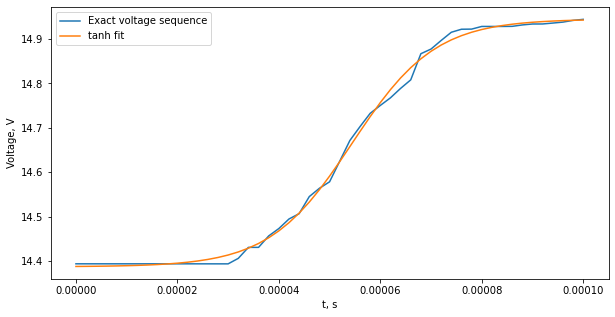

In [14]:
# plot 0th electrode voltage sequence and approximation
def fitter_tan(t):
    return ((0.279) * (1 - 2/(exp(2*((61284.969) *t + (-3.339))) + 1)) + (14.666))

x_data = np.arange(res+1)*T/res

fig = plt.figure(figsize = [10,5])
plt.plot(x_data, voltage_seq[0], label = 'Exact voltage sequence')
plt.plot(x_data, fitter_tan(x_data), label = 'tanh fit')
plt.legend()
plt.xlabel('t, s')
plt.ylabel('Voltage, V')
plt.show()

# Shuttling simulation

The following block performs shuttling simulation with the previously determined voltage sequences on DC electrodes. In general, the *sion.polygon_shuttling()* function performs simulation with arbitrary voltage sequences, approximated with analytic functions, not only shuttling. 

The simulation time is chosen to match the time of shuttling operation, however the choice of fitting functions allows to extend the simulation to the process, where DC voltages stop changing. In Sion one step of simulation corresponds to $1/20\Omega_{RF}$.

In [15]:
positions = np.array(sn.ioncloud_min(x0, 1, 0))*L

name = Path('linear_shuttling.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}


rf_set = [Vrf, Vrf]
Omegas = [Omega for i in range(2)]

print(positions)
sim.append(pl.placeions(Caions, positions))

#reshape elec coordinates for polygon form
RF_electrodes=[]
for iterr in range(2):
    RF_electrodes.append(elec[0][1][iterr])
DC_electrodes = []
for ite in range(Numb):
    DC_electrodes.append(elec[ite + 1][1][0])

sim.append(sn.polygon_shuttling(Omegas, rf_set, RF_electrodes, DC_electrodes, funcs))

sim.append(pl.langevinbath(0, 1e-6))

sim.append(pl.dump('posshuttle.txt', variables=['x', 'y', 'z'], steps=10))

t_evolve = int(T*20*Omega)

sim.append(pl.evolve(t_evolve))

sim.execute()

_, data = pl.readdump('posshuttle.txt')
data *=1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

[[-5.00000000e-06  9.99877277e-05  1.99847827e-04]]
Reducing timestep to 9.947183943243459e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Setting atom values ...
  1 settings made for charge
1 atoms in group 1
1 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 9.94718e-10
Per MPI rank memory allocation (min/avg/max) = 1.405 | 1.405 | 1.405 Mbytes
S

C:\Users\a.podlesnyy\anaconda3\lib\site-packages\pylion-0.5.0-py3.8.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Plot of ion trajectory

<ipython-input-16-4d2666039b09>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


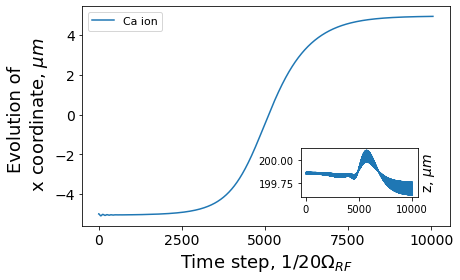

In [16]:
#plotting routine
fig, ax = plt.subplots(1,1,figsize = [6.5, 4] )
ax.plot(data[:, 0, 0], label = 'Ca ion')
plt.locator_params(axis='x', nbins=5)
ax.legend(prop = {'size': 11}, ncol = 2)
ax.tick_params(axis='both', which='major', labelsize=14)
left, bottom, width, height = [0.65, 0.3, 0.25, 0.17]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(data[:, 0, 2])
ax2.set_ylabel('z, $\mu m$', fontsize = 14)
ax2.yaxis.set_label_position("right")
ax.set_ylabel('Evolution of \n x coordinate, $\mu m$', fontsize = 18)
ax.set_xlabel('Time step, $1/20\Omega_{RF}$', fontsize = 18)
plt.tight_layout()
plt.show()